In [1]:
## Visualize the trained model

import sys
#sys.path.append('deps/sparse_rrt')
sys.path.append('.')
import torch
import torch.nn as nn
import importlib
#from model import ae_s2d
#from model import cvae_s2d_model1 as cvae_s2d

from model.SMPNet import SMPNet
from model.SMPPathNet import SMPPathNet
from model.SMPPathWithPriorNet import SMPPathWithPriorNet

#from tools import data_loader
from tools.utility import *
#from plan_utility import cart_pole, cart_pole_obs, pendulum, acrobot_obs, car_obs
import argparse
import numpy as np
import random
import os
from tqdm import tqdm, trange


In [2]:
import yaml
# try:
#     from yaml import CLoader as Loader, CDumper as Dumper
# except ImportError:
#     from yaml import Loader, Dumper

parser = argparse.ArgumentParser()
# for training
parser.add_argument('--param_path', type=str, default='param/train/',help='path for loading training param')
parser.add_argument('--param_name', type=str, default="cvae_s2d_param3.yaml")

# parse the parameter file
args = parser.parse_args("")
print(args)
param_f = open(args.param_path+args.param_name, 'r')
param = yaml.load(param_f)
param = DictDot(param)
args = param
args.start_epoch = 3
args.s = 0
args.sp = 4000
args.start_iter =  6000

Namespace(param_name='cvae_s2d_param3.yaml', param_path='param/train/')


<ipython-input-2-2731af580cbe>:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  param = yaml.load(param_f)


In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(args.device)
# environment setting
cae = None
mlp = None

# load net
# load previously trained model if start epoch > 0

# dynamically import model
ae_module = importlib.import_module('model.ae_%s_model_%d' % (args.env_type, args.model_id))
cvae_module = importlib.import_module('model.cvae_%s_model_%d' % (args.env_type, args.model_id))
e_net = ae_module.Encoder(input_size=args.e_net_input_size, output_size=args.e_net_output_size)
cvae = cvae_module.CVAE(input_size=args.input_size, latent_size=args.latent_size, cond_size=args.cond_size)

data_loader = importlib.import_module('tools.data_loader_%s' % (args.env_type))
plan_util = importlib.import_module('plan_util.%s' % (args.env_type))
normalize = plan_util.normalize
unnormalize = plan_util.unnormalize

if args.model_type == "SMPNet":
    smpnet = SMPNet(e_net, cvae)
elif args.model_type == "SMPPathNet":
    smpnet = SMPPathNet(e_net, cvae)
elif args.model_type == "SMPPathWithPriorNet":
    smpnet = SMPPathWithPriorNet(e_net, cvae)


model_dir = args.model_dir + '%s/%s/model_%d/param_%s/' % (args.env_type, args.model_type, args.model_id, args.param_name)
model_path='smpnet_epoch_%d_iter_%d.pkl' %(args.start_epoch, args.start_iter)
torch_seed, np_seed, py_seed = 0, 0, 0
if args.start_epoch > 0:
    load_net_state(smpnet, os.path.join(model_dir, model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)

if torch.cuda.is_available():
    smpnet.cuda()
    smpnet.cvae.cuda()
    smpnet.e_net.cuda()
    if args.opt == 'Adagrad':
        smpnet.set_opt(torch.optim.Adagrad, lr=args.learning_rate)
    elif args.opt == 'Adam':
        smpnet.set_opt(torch.optim.Adam, lr=args.learning_rate)
    elif args.opt == 'SGD':
        smpnet.set_opt(torch.optim.SGD, lr=args.learning_rate, momentum=0.9)
    elif args.opt == 'ASGD':
        smpnet.set_opt(torch.optim.ASGD, lr=args.learning_rate)
if args.start_epoch > 0:
    load_opt_state(smpnet, os.path.join(model_dir, model_path))
data_folder = args.data_folder+args.env_type+'/'
print(args.model_type)
load_dis_ratio = None
if args.model_type == "SMPPathNet":
    load_dis_ratio = True
elif args.model_type == "SMPPathWithPriorNet":
    load_dis_ratio = True
elif args.model_type == "SMPNet":
    load_dis_ratio = False

length of the output of one encoder
343
SMPPathWithPriorNet


In [4]:
# test to see the error
waypoint_dataset, cond_dataset, obs, env_indices \
         = data_loader.load_train_dataset(N=10, NP=200, s=0, sp=0,
                                            data_folder=data_folder, load_dis_ratio=load_dis_ratio)
cond_dataset = np.array(cond_dataset)
# randomize the dataset before training
data=list(zip(waypoint_dataset, cond_dataset, env_indices))
random.shuffle(data)
waypoint_dataset,cond_dataset,env_indices=list(zip(*data))
waypoint_dataset = list(waypoint_dataset)
cond_dataset = list(cond_dataset)
env_indices = list(env_indices)
waypoint_dataset = np.array(waypoint_dataset)
cond_dataset = np.array(cond_dataset)
env_indices = np.array(env_indices)

smpnet.eval()
epoch_val_num = 2048
waypoint_dataset_i = waypoint_dataset[:epoch_val_num]
cond_dataset_i = cond_dataset[:epoch_val_num]
env_indices_i = env_indices[:epoch_val_num]
bi = waypoint_dataset_i
bi = torch.FloatTensor(bi)
bi = normalize(bi, args.world_size)
bi=to_var(bi)

cond_dataset_i = torch.FloatTensor(cond_dataset_i)
cond_dataset_i = normalize(cond_dataset_i, args.world_size)  # assume the first Sx2 are start and goal
cond_dataset_i = to_var(cond_dataset_i)

bobs = obs[env_indices_i].astype(np.float32)
bobs = torch.FloatTensor(bobs)
bobs = to_var(bobs)
loss = smpnet.loss(bi, smpnet.train_forward(bi, cond_dataset_i, bobs), beta=args.beta)
loss = torch.mean(loss)
print('mean loss: %f' % (loss.cpu().item()))



mean loss: 0.006213


In [5]:
obs_idx = 3
path_idx = 150

# test to see the error
waypoint_dataset, cond_dataset, obs, env_indices \
         = data_loader.load_train_dataset(N=1, NP=1, s=args.s+obs_idx, sp=args.sp+path_idx,
                                            data_folder=data_folder, load_dis_ratio=load_dis_ratio)

cond_dataset = np.array(cond_dataset)
# randomize the dataset before training
data=list(zip(waypoint_dataset, cond_dataset, env_indices))
random.shuffle(data)
waypoint_dataset,cond_dataset,env_indices=list(zip(*data))
waypoint_dataset = list(waypoint_dataset)
cond_dataset = list(cond_dataset)
env_indices = list(env_indices)
waypoint_dataset = np.array(waypoint_dataset)
cond_dataset = np.array(cond_dataset)
env_indices = np.array(env_indices)

smpnet.eval()
epoch_val_num = 2048
waypoint_dataset_i = waypoint_dataset[:epoch_val_num]
cond_dataset_i = cond_dataset[:epoch_val_num]
env_indices_i = env_indices[:epoch_val_num]
bi = waypoint_dataset_i
bi = torch.FloatTensor(bi)
bi = normalize(bi, args.world_size)
bi=to_var(bi)

cond_dataset_i = torch.FloatTensor(cond_dataset_i)
cond_dataset_i = normalize(cond_dataset_i, args.world_size)  # assume the first Sx2 are start and goal
cond_dataset_i = to_var(cond_dataset_i)

bobs = obs[env_indices_i].astype(np.float32)
bobs = torch.FloatTensor(bobs)
bobs = to_var(bobs)
loss = smpnet.loss(bi, smpnet.train_forward(bi, cond_dataset_i, bobs), beta=args.beta)
loss = torch.mean(loss)
print('mean loss: %f' % (loss.cpu().item()))

output = smpnet.train_forward(bi, cond_dataset_i, bobs, L=1)
gen_loss = smpnet.generation_loss(bi, output)
gen_loss = torch.mean(gen_loss)
print('generation loss: %f' % (gen_loss.cpu().item()))

kl_loss = smpnet.kl_divergence(bi, output)
kl_loss = torch.mean(kl_loss)
print('KL loss: %f' % (kl_loss.cpu().item()))

prior_z_mu, prior_z_log_sigma_pow2, z_mu,z_log_sigma_pow2, z, x_mu = output
print('reconstruction: ')
print(x_mu)
print(x_mu.size())
print('ground truth:')
print(bi.cpu().data)

print('condition:')
print(cond_dataset_i[:10])

print('prior_z_mu:')
print(prior_z_mu)
print('prior_z_log_sigma_pow2:')
print(prior_z_log_sigma_pow2)

print('rec_z_mu:')
print(z_mu)
print('rec_z_log_sigma_pow2:')
print(z_log_sigma_pow2)

mean loss: 0.006243
generation loss: 0.006284
KL loss: 0.000010
reconstruction: 
tensor([[[-0.5404,  0.6372],
         [ 0.3390,  0.8312],
         [-0.0448,  0.7321],
         [ 0.4369,  0.8837],
         [-0.2810,  0.6913],
         [-0.8182,  0.6717]]], device='cuda:0', grad_fn=<ViewBackward>)
torch.Size([1, 6, 2])
ground truth:
tensor([[-0.5430,  0.7476],
        [ 0.3043,  0.9152],
        [-0.0288,  0.8600],
        [ 0.4537,  0.9093],
        [-0.2525,  0.8086],
        [-0.9673,  0.6481]])
condition:
tensor([[-0.9673,  0.6481,  0.4537,  0.9093,  0.3007],
        [-0.9673,  0.6481,  0.4537,  0.9093,  0.8968],
        [-0.9673,  0.6481,  0.4537,  0.9093,  0.6639],
        [-0.9673,  0.6481,  0.4537,  0.9093,  1.0000],
        [-0.9673,  0.6481,  0.4537,  0.9093,  0.5055],
        [-0.9673,  0.6481,  0.4537,  0.9093,  0.0000]], device='cuda:0')
prior_z_mu:
tensor([[-0.0467, -0.0009],
        [-0.0473, -0.0005],
        [-0.0474, -0.0005],
        [-0.0470, -0.0008],
        [-0.04

In [6]:
# load test data
print('loading...')
obs_center, obs, paths, path_lengths = \
        data_loader.load_test_dataset(N=args.no_env, NP=args.no_motion_paths, \
                                      s=args.s, sp=args.sp, folder=data_folder)
obs_width = 5.


loading...


In [7]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def cvae_visualization(smpnet, obs_idx, path_idx, dist_val, num_sample=10):
    # visualize the planning scene and samples
    obs_center_i = obs_center[obs_idx]
    obs_i = obs[obs_idx]
    path_i = paths[obs_idx][path_idx]
    path_length_i = path_lengths[obs_idx][path_idx]
    #print(path_length_i)
    assert path_length_i > 2
    #dist = np.linspace(0., 1., 10)
    dist = np.array([dist_val])
    #print(dist)
    dist = np.repeat(dist, num_sample).reshape(-1,1)

    #dist = np.repeat(dist, num_sample//10).reshape(-1,1)
    #print(dist.shape)
    start_i = np.array([path_i[0]])
    goal_i = np.array([path_i[path_length_i-1]])
    start_i = np.tile(start_i, [num_sample, 1])
    goal_i = np.tile(goal_i, [num_sample, 1])
    cond_dataset_i = np.concatenate([start_i, goal_i, dist], axis=1)
    cond_dataset_i = torch.FloatTensor(cond_dataset_i)
    cond_dataset_i = normalize(cond_dataset_i, args.world_size)  # assume the first Sx2 are start and goal
    cond_dataset_i = to_var(cond_dataset_i)
    
    #print([num_sample]+list(obs_i.shape))
    bobs = torch.FloatTensor(obs_i).unsqueeze(0).repeat([num_sample, 1, 1, 1])
    bobs = to_var(bobs)
    #print(bobs.size())
    
    
    # generating
    samples = smpnet.gen_forward(cond_dataset_i, obs=bobs, obs_z=None)
    samples = samples.cpu().data
    samples = unnormalize(samples, args.world_size).numpy()
    
    # visualize
    # show obstacles
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim(-22, 22)
    ax.set_ylim(-22, 22)
    #print(obs_center_i.shape)

    for i in range(len(obs_center_i)):
        x, y = obs_center_i[i][0], obs_center_i[i][1]
        obs_patch_i = patches.Rectangle((x-obs_width/2,y-obs_width/2),\
                                       obs_width,obs_width,\
                                       linewidth=0.0, facecolor='black')
        ax.add_patch(obs_patch_i)
    
    # show start and goal
    ax.scatter([path_i[0][0]], [path_i[0][1]], c='green', s=100.0)
    ax.scatter([path_i[path_length_i-1][0]], [path_i[path_length_i-1][1]], c='red', s=100.0, marker='*')
    
    # show path
    ax.plot(path_i[:path_length_i,0], path_i[:path_length_i,1], c='pink')
    ax.scatter(path_i[1:-1,0], path_i[1:-1,1], c="pink", s=100)
    # show samples
    ax.scatter(samples[:,0], samples[:,1], c='blue', s=50.)
    
    return fig

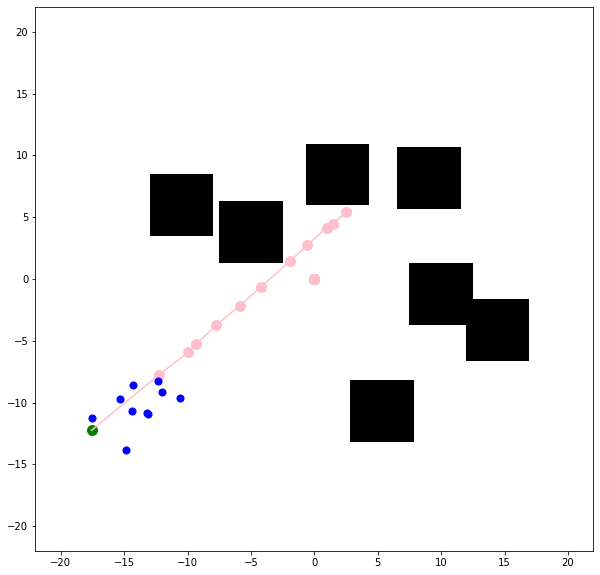

In [8]:
fig = cvae_visualization(smpnet, 1, 140, dist_val=0.1,num_sample=10)
plt.show()


In [9]:
print(path_lengths)

[[ 3  5  9 ...  0  0  0]
 [14  6  9 ...  0  0  0]
 [ 2 17  6 ...  0  0  0]
 ...
 [14  5  6 ...  0  0  0]
 [10 17  7 ...  0  0  0]
 [ 3 21  2 ...  0  0  0]]


In [10]:
model_fs = [f for f in os.listdir(model_dir) if 'smpnet_epoch_' in f and 'iter' in f]
def get_epoch_itr(v_str):
    idx = v_str.split('epoch_')[1]
    idx = idx.split('_iter_')
    epoch = int(idx[0])
    itr = int(idx[1][:-4])
    return (epoch, itr)
model_fs = sorted(model_fs, key=get_epoch_itr)
print(model_fs)

['smpnet_epoch_1_iter_0.pkl', 'smpnet_epoch_1_iter_2000.pkl', 'smpnet_epoch_1_iter_4000.pkl', 'smpnet_epoch_1_iter_6000.pkl', 'smpnet_epoch_1_iter_8000.pkl', 'smpnet_epoch_1_iter_10000.pkl', 'smpnet_epoch_2_iter_0.pkl', 'smpnet_epoch_2_iter_2000.pkl', 'smpnet_epoch_2_iter_4000.pkl', 'smpnet_epoch_2_iter_6000.pkl', 'smpnet_epoch_2_iter_8000.pkl', 'smpnet_epoch_2_iter_10000.pkl', 'smpnet_epoch_3_iter_0.pkl', 'smpnet_epoch_3_iter_2000.pkl', 'smpnet_epoch_3_iter_4000.pkl', 'smpnet_epoch_3_iter_6000.pkl', 'smpnet_epoch_3_iter_8000.pkl']


In [11]:
def gen_figs(obs_idx, path_idx, num_dist, num_sample=100):
    for model_f in model_fs:
        if model_f == 'smpnet_epoch_10_iter_1000.pkl':
            continue
        smpnet = SMPNet(e_net, cvae)
        smpnet.eval()
        model_path=model_f
        load_net_state(smpnet, os.path.join(model_dir, model_path))
        torch_seed, np_seed, py_seed = load_seed(os.path.join(model_dir, model_path))
        # set seed after loading
        torch.manual_seed(torch_seed)
        np.random.seed(np_seed)
        random.seed(py_seed)

        if torch.cuda.is_available():
            smpnet.cuda()
            smpnet.cvae.cuda()
            smpnet.e_net.cuda()
        dist_vals = np.linspace(0.,1.,num_dist)
        for dist_val in dist_vals:
            fig = cvae_visualization(smpnet, obs_idx, path_idx, dist_val, num_sample=num_sample);
            os.makedirs('plots/%s/param_%d/' % (args.model_type, args.param_name), exist_ok=True)
            plt.savefig("plots/%s/param_%d/env_%d_path_%d_dist_%f_%s.png" % (args.model_type, args.param_name, \
                                                                            obs_idx+args.s, path_idx+args.sp, \
                                                                            dist_val, model_f[:-4]));
            plt.close(fig)

In [12]:
!pip install imageio

In [13]:
import imageio
def make_video(obs_idx, path_idx, dist_val):
    def tryint(s):
        try:
            return int(s)
        except ValueError:
            return s
    def str2int(v_str):
        idx = v_str.split('epoch_')[1]
        idx = int(idx[:-4])
        return idx
    def get_epoch_itr(v_str):
        idx = v_str.split('epoch_')[1]
        idx = idx.split('_iter_')
        epoch = int(idx[0])
        itr = int(idx[1][:-4])
        return (epoch, itr)

    def sort_humanly(v_list):
        return sorted(v_list, key=get_epoch_itr)
    image_folder = 'plots/%s/param_%d/' % (args.model_type, args.param_name)
    
    os.makedirs('video/%s/param_%d' % (args.model_type, args.param_name), exist_ok=True)
    video_name = 'video/{}/param_{}/env_{}_path_{}_dist_{}.gif'.format(args.model_type, args.param_name, obs_idx, path_idx, dist_val)
    images = [img for img in os.listdir(image_folder) \
              if 'env_%d_path_%d' % (obs_idx+args.s, path_idx+args.sp) in img and 'iter' in img \
                 and 'dist_%f' % (dist_val) in img]
    images = sort_humanly(images)
    imgs = []
    for filename in images:
#         print('./'+image_folder+'/'+filename)
        imgs.append(imageio.imread('./'+image_folder+'/'+filename))
    imageio.mimsave(video_name, imgs)

In [14]:
# save figure for different model
for obs_idx in range(10):
    path_idxs = []
    count = 0
    while True:
        path_idx = np.random.choice(200)
        if path_lengths[obs_idx][path_idx] < 5:
            continue
        if path_idx in path_idxs:
            continue
        count += 1
        path_idxs.append(path_idx)
        num_dist = 11
        gen_figs(obs_idx, path_idx, num_dist=num_dist, num_sample=20)
        dist_vals = np.linspace(0.,1.,num_dist)
        for dist_val in dist_vals:
            make_video(obs_idx, path_idx, dist_val)
        print('count: %d' % (count))
        if count == 2:
            break

count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2
count: 1
count: 2


In [15]:
#make_video(obs_idx+args.s, path_idx+args.sp)